In [17]:
import warnings
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, LearningCurveDisplay
from sklearn.metrics import make_scorer, root_mean_squared_error

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from xgboost import XGBRegressor

from utils.trainer import Trainer, ARIMATrainer
from utils.tuner import ARIMATuner, XGBTuner
from utils.pairs import PairsFinder
from utils.trader import AutoTrader

## **WARNING**

**The functions here are run using data that is current as of the writing of this Jupyter notebook. As such, if the notebook is re-run, results may differ from what is shown here.**

## **Exploratory Analysis**

Selected pairs: [('AAPL', 'LNVGY'), ('NVDA', 'DELL'), ('AMD', 'DELL'), ('AMD', 'LNVGY'), ('AMD', 'MSFT'), ('DELL', 'MSFT')]


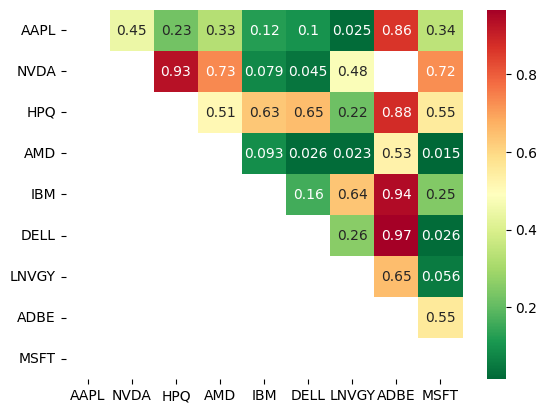

In [2]:
stocks = ['AAPL', 'NVDA', 'HPQ', 
          'AMD', 'IBM', 'DELL', 
          'LNVGY', 'ADBE', 'MSFT']

pairs_finder = PairsFinder()

pairs = pairs_finder.plot_coint_heatmap(stocks)

print(f'Selected pairs: {pairs}')


Hedge Ratio: 1.0


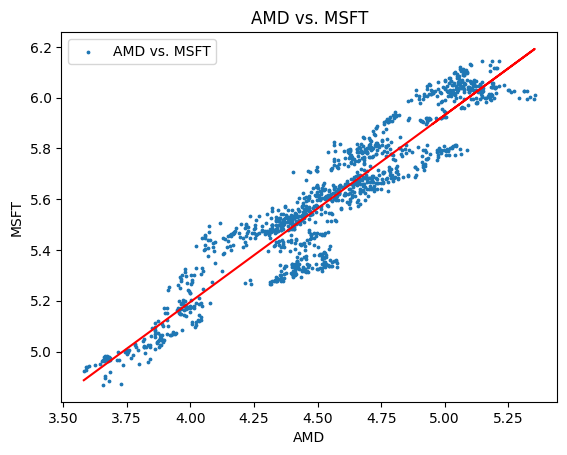

In [3]:
pair = ('AMD', 'MSFT')

pairs_finder.plot_hedge_ratio(pair)

_, hedge_ratio = pairs_finder.get_hedge_ratio(pair)

print(f'Hedge Ratio: {hedge_ratio}')

plt.title(pair[0] + ' vs. ' + pair[1]) 

plt.show()

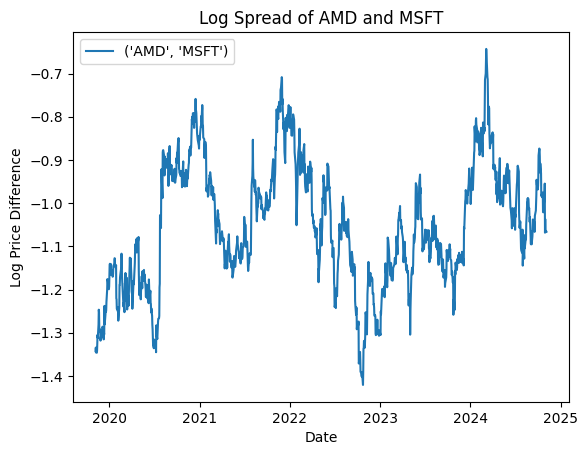

In [4]:
pairs_finder.plot_spread(pair)
plt.title('Log Spread of ' + pair[0] +  ' and ' + pair[1])
plt.show()

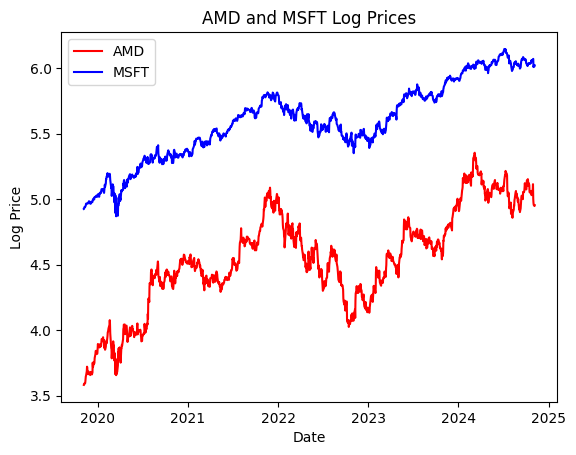

In [5]:
amd = np.log(yf.Ticker(pair[0]).history(period='5y')['Close'])
dell = np.log(yf.Ticker(pair[1]).history(period='5y')['Close'])

plt.plot(amd.index, amd, label=pair[0], color='red')
plt.plot(dell.index, dell, label=pair[1], color='blue')

plt.title(pair[0] + ' and ' + pair[1] + ' Log Prices')
plt.xlabel('Date')
plt.ylabel('Log Price')

plt.legend()

plt.show()

p-value of ADF test: 0.02209405949535845
The time series is stationary


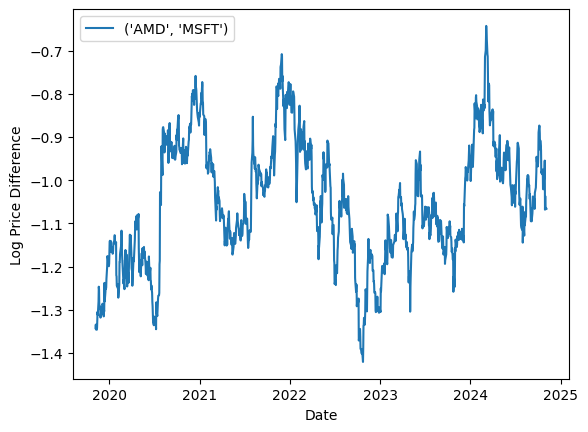

In [6]:
pairs_finder.plot_spread(pair)

spread = pairs_finder.get_spread(pair)

spread_train, spread_test = train_test_split(
    spread,
    test_size=0.2,
    train_size=0.8,
    shuffle=False
)

trainer = Trainer()

_ = trainer.is_stationary(spread_train)

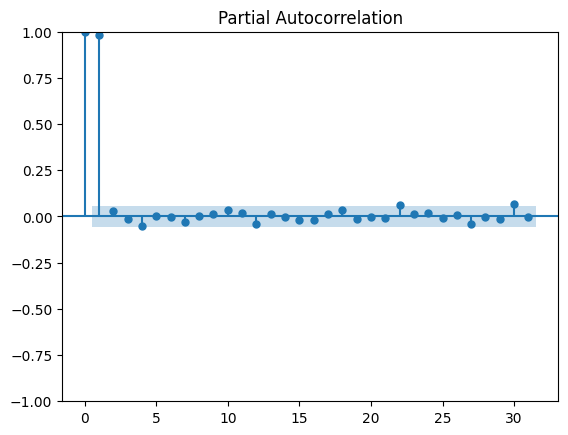

In [7]:
plot_pacf(spread)

plt.show()

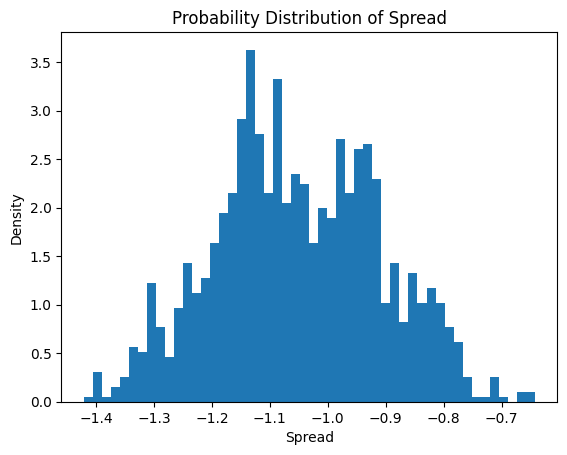

In [8]:
spread_list = spread.reset_index()['Close'].to_list()


spread_list.sort()

plt.hist(spread_list, bins=50, density=True)

plt.title('Probability Distribution of Spread')

plt.xlabel('Spread')
plt.ylabel('Density')

plt.show()

## **XGBoost Model**

In [23]:
lags = range(1, 6)

target = 'Close'

price_x = yf.Ticker(pair[0]).history(period='5y')
price_x['Open_Yesterday'] = price_x['Open'].shift()
# price_x = price_x.drop('Open', axis=1)
price_y = yf.Ticker(pair[1]).history(period='5y')
price_y['Open_Yesterday'] = price_y['Open'].shift()
# price_y = price_y.drop('Open', axis=1)

price_x = trainer.generate_features(price_x)
price_x = price_x.add_suffix('_X')

price_y = trainer.generate_features(price_y)
price_y = price_y.add_suffix('_Y')

df = pd.concat([price_x, price_y, spread], axis=1)

df = trainer.generate_out_of_sample_features(df, lags, target)

df.drop(['Low_X', 'High_X'], axis=1, inplace=True)

x = df.drop(target, axis=1)
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=False)

In [27]:
xgb_optimiser = XGBTuner().bayesian_optimisation(x_train, y_train)

print(xgb_optimiser.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963
[CV 1/5; 1/1] END gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963;, score=0.603 total time=   0.4s
[CV 2/5; 1/1] START gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963
[CV 2/5; 1/1] END gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963;, score=-1.695 total time=   0.2s
[CV 3/5; 1/1] START gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963
[CV 3/5; 1/1] END gamma=0.7472673526804974, learning_rate=0.3445759509029631, max_depth=8, n_estimators=576, reg_lambda=0.5538174195777963;, score=-2.193 total time=   0.4s


In [31]:
xgb_params = {'gamma': 0.01, 'learning_rate': 0.8092268420278115, 'max_depth': 3, 'n_estimators': 365, 'reg_lambda': 0.35956317089871537}

xgb = XGBRegressor(
    learning_rate=xgb_params['learning_rate'],
    max_depth=xgb_params['max_depth'],
    n_estimators=xgb_params['n_estimators'],
    reg_lambda=xgb_params['reg_lambda'],
    gamma=xgb_params['gamma']
    )

RMSE: 0.10040428754380451


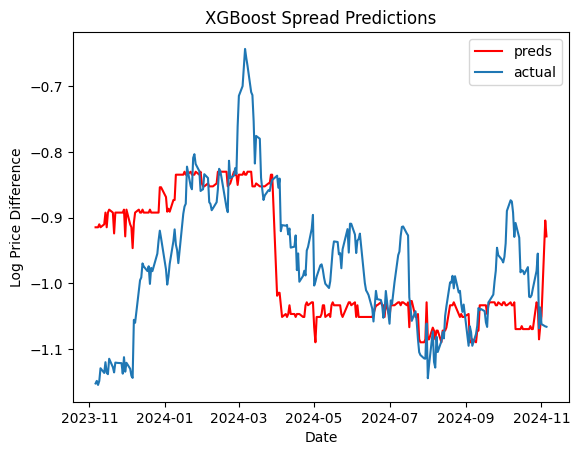

In [32]:
xgb.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=False
    )

y_preds = xgb.predict(x_test)

print(f'RMSE: {root_mean_squared_error(y_preds, y_test)}')

plt.title('XGBoost Spread Predictions')
plt.xlabel('Date')
plt.ylabel('Log Price Difference')

plt.plot(y_test.index, y_preds, label='preds', color='red')
plt.plot(y_test.index, y_test, label='actual')

plt.legend()
plt.show()

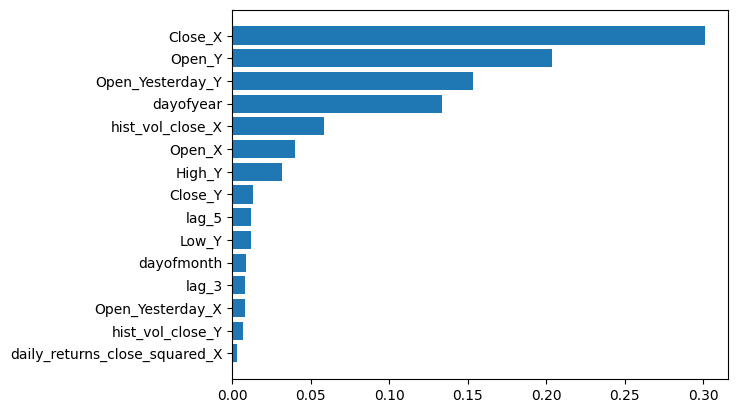

In [33]:
_ = trainer.plot_importance(xgb, 15)

In [22]:
mse = make_scorer(root_mean_squared_error)

train_sizes, train_scores, test_scores = learning_curve(estimator=xgb, X=x_train, y=y_train, scoring=mse)

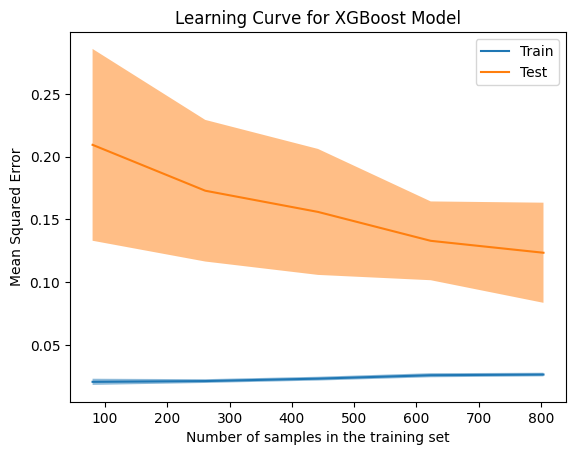

In [23]:
lc_display = LearningCurveDisplay(
    train_sizes=train_sizes, 
    train_scores=train_scores, 
    test_scores=test_scores, 
    score_name='Mean Squared Error'
)
lc_display.plot()
plt.title('Learning Curve for XGBoost Model')
plt.legend()
plt.show()

In [13]:
trader = AutoTrader(pair[0], pair[1], 10000)
xgb_results = trader.xgb_trade(y_preds, y_train, y_test)

Final Balance: $12479.05
Return: 24.79%
Annualised Sharpe Ratio: 5.43


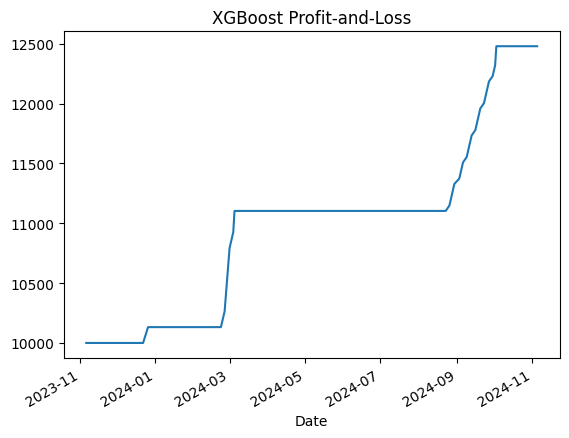

In [14]:
xgb_results['money'].plot()
plt.title('XGBoost Profit-and-Loss')
plt.show()

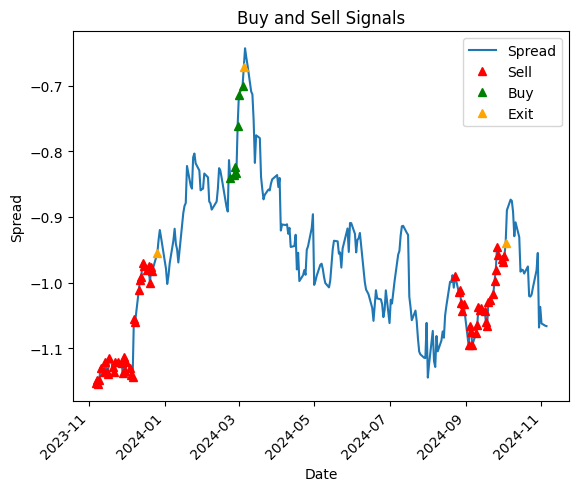

In [15]:
trader.plot_buy_sell(y_test, xgb_results)

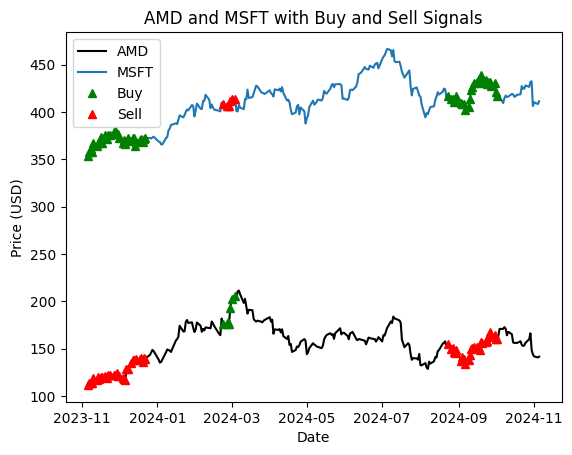

In [16]:
trader.plot_buy_sell_stock(xgb_results)

## **Tuning ARIMA Model**

In [18]:
warnings.filterwarnings(action='ignore')

param_space = {
    'p': [1,2,3,4],
    'q': [1,2,3,4],
    'd': [0, 1, 2]
}

arima_tuner = ARIMATuner()

best_params  = arima_tuner.grid_search(param_space, 'aic', spread_train)

AIC score = -4497.161882243927, cfg = (1, 1, 0)
AIC score = -4495.139532891737, cfg = (1, 1, 1)
AIC score = -4493.138877073417, cfg = (1, 1, 2)
AIC score = -4071.418175921097, cfg = (1, 2, 0)
AIC score = -4482.785269062863, cfg = (1, 2, 1)
AIC score = -4480.965453068616, cfg = (1, 2, 2)
AIC score = -3245.290701699464, cfg = (1, 3, 0)
AIC score = -4056.626629162853, cfg = (1, 3, 1)
AIC score = -4458.486176431675, cfg = (1, 3, 2)
AIC score = -2266.072770349073, cfg = (1, 4, 0)
AIC score = -3230.7147991567845, cfg = (1, 4, 1)
AIC score = -4027.8867403688164, cfg = (1, 4, 2)
AIC score = -4495.21651473344, cfg = (2, 1, 0)
AIC score = -4493.211323456002, cfg = (2, 1, 1)
AIC score = -4491.774969325548, cfg = (2, 1, 2)
AIC score = -4210.249049703896, cfg = (2, 2, 0)
AIC score = -4480.707947237133, cfg = (2, 2, 1)
AIC score = -4479.232832851226, cfg = (2, 2, 2)
AIC score = -3552.220825071586, cfg = (2, 3, 0)
AIC score = -4194.651108397929, cfg = (2, 3, 1)
AIC score = -4384.729105994699, cfg = (

In [19]:
print(best_params)

(1, 1, 0)


RMSE: 0.07778786566836438


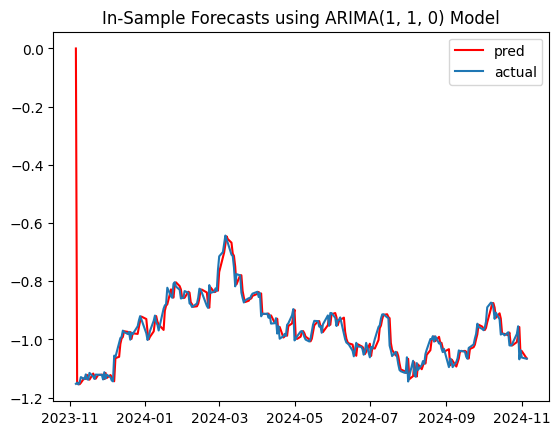

In [21]:
model = ARIMA(spread_test, order=best_params)

predictions = model.fit().predict()

print(f'RMSE: {root_mean_squared_error(predictions, spread_test)}')

plt.title('In-Sample Forecasts using ARIMA' + str(best_params) +' Model')

plt.plot(spread_test.index, predictions, label='pred', color='red')
plt.plot(spread_test.index, spread_test, label='actual')
plt.legend()
plt.show()

RMSE: 0.05608796884098334


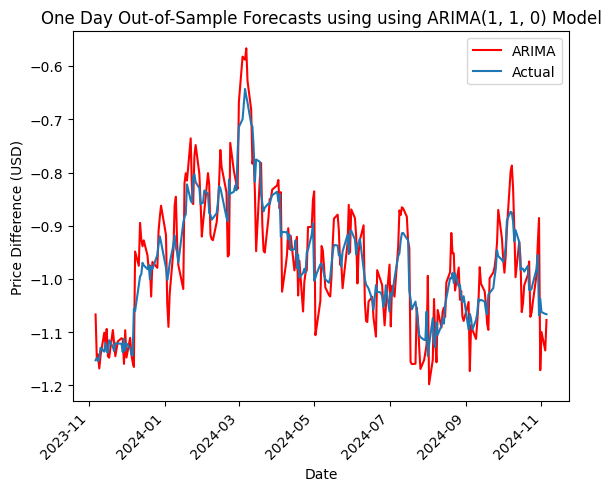

In [22]:
arima_trainer = ARIMATrainer()

preds = arima_trainer.walk_forward_eval(best_params, spread_train, spread_test)

plt.plot(spread_test.index, preds, label='ARIMA', color='red')
plt.plot(spread_test.index, spread_test, label='Actual')

plt.title('One Day Out-of-Sample Forecasts using using ARIMA' + str(best_params) + ' Model')
plt.xlabel('Date')
plt.ylabel('Price Difference (USD)')

plt.xticks(rotation=45, ha='right')
plt.legend()

plt.show()

## **Pairs Trading**

In [12]:
trader = AutoTrader(pair[0], pair[1], 10000)

results = trader.trade(best_params, y_train, y_test)

Final Balance: $10749.25
Cumulative Return: 7.49%
Annualised Sharpe Ratio: 2.67


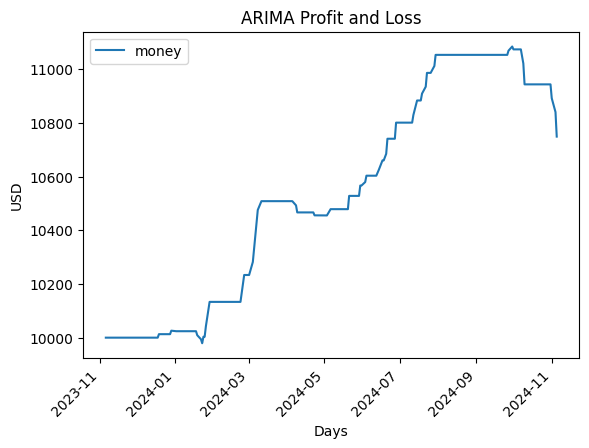

In [13]:
results['money'].plot()

plt.xticks(rotation=45, ha='right')

plt.title('ARIMA Profit and Loss')
plt.xlabel('Days')
plt.ylabel('USD')

plt.legend()

plt.show()

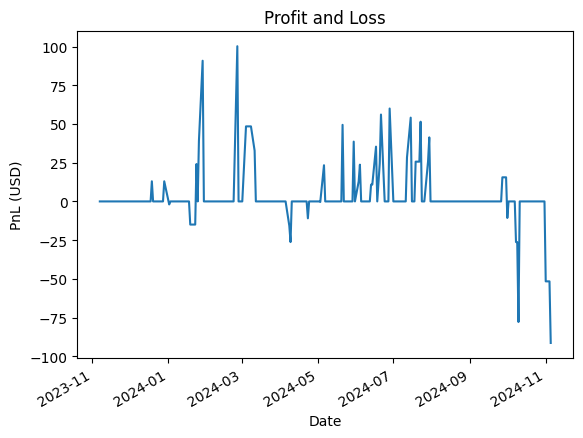

In [14]:
results['PnL'].plot()
plt.title('Profit and Loss')
plt.xlabel('Date')
plt.ylabel('PnL (USD)')
plt.show()

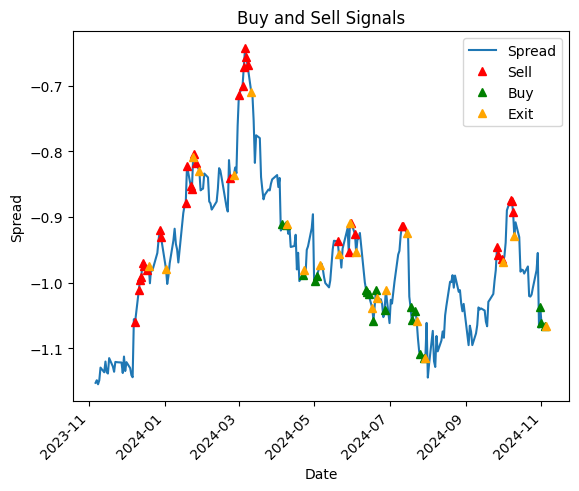

In [18]:
trader.plot_buy_sell(spread_test, results)

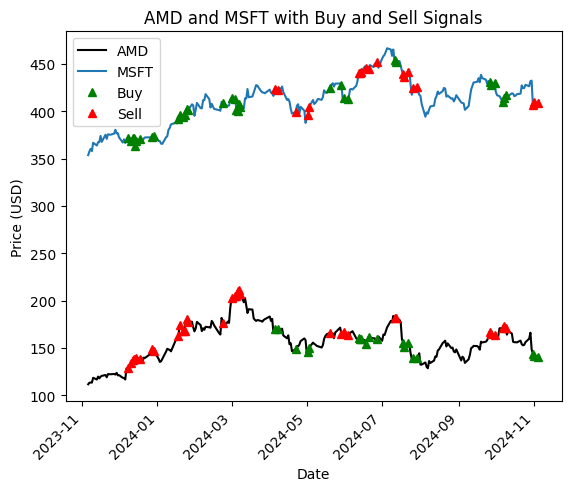

In [16]:
trader.plot_buy_sell_stock(results)
plt.xticks(ha='right', rotation=45)
plt.show()